In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Embedding, GlobalMaxPool1D, BatchNormalization, Input, Bidirectional, GlobalAveragePooling1D, Conv1D, MaxPooling1D, AveragePooling1D, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

In [ ]:
## TYPE YOUR CODE for task 2 here:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# HYPER PARAMS

In [ ]:
length = 300 # how many X used to predict y (# of dates back used for prediction)
forecast = 150 # predict more than current data (future beyond current date) (# of dates predicted)

random_state = 1 # data splitting random state
train_size = 0.7 # data portion for training

# % price diff bounds (for VNIndex: +/- 0.07)
bounds = (-0.07, 0.07) 
bounds_output = (-0.07, 0.07)

corr_min = 0.02 # min corr score of selected feature

standardize_label = False
standardize_input = True

drop_rate = 0.2
kicks = 1 # times to re-train the model
epochs = 80 # epoch for each kick
batch_size = 128

**Load data from Drive**

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/BCE/data4.xlsx')
data.loc[:, ['diff_close_%']] = np.clip(data.loc[:, ['diff_close_%']], bounds[0], bounds[1])
data.loc[:, ['diff_open_%']] = np.clip(data.loc[:, ['diff_open_%']], bounds[0], bounds[1])
data

,Ngày,open,diff_open,diff_open_%,close,diff_close,diff_close_%,volume,KLGD thỏa thuận,volume_total,...,FSI_80,FSI_20,BOU,BOL,close_BOU,close_BOL,close_BOU_%,close_BOL_%,close_BOU_yn,BOL_close_yn
0,2011-04-22,8800,200,0.0233,8500,-300,-0.0341,1960,0,1960,...,-1,1,10190.697729,7889.302271,-1690.697729,610.697729,-0.165906,0.077408,-1,-1
1,2011-04-25,8500,-300,-0.0341,8700,200,0.0235,6610,0,6610,...,-1,1,10132.754139,7827.245861,-1432.754139,872.754139,-0.141398,0.111502,-1,-1
2,2011-04-26,8700,200,0.0235,8500,-200,-0.0230,8210,0,8210,...,-1,1,10034.506329,7745.493671,-1534.506329,754.506329,-0.152923,0.097412,-1,-1
3,2011-04-27,8500,-200,-0.0230,8500,0,0.0000,1340,0,1340,...,-1,1,9941.559414,7658.440586,-1441.559414,841.559414,-0.145003,0.109887,-1,-1
4,2011-04-28,8500,0,0.0000,8600,100,0.0118,4510,0,4510,...,-1,1,9759.027886,7680.972114,-1159.027886,919.027886,-0.118765,0.119650,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2694,2022-09-02,15350,400,0.0268,15250,-100,-0.0065,222300,0,22230,...,-1,-1,19212.216171,10567.783829,-3962.216171,4682.216171,-0.206234,0.443065,-1,-1
2695,2022-10-02,15250,-100,-0.0065,14950,-300,-0.0197,237300,0,23730,...,-1,1,18966.616230,10563.383770,-4016.616230,4386.616230,-0.211773,0.415266,-1,-1
2696,2022-11-02,14950,-300,-0.0197,15350,400,0.0268,327900,0,32790,...,-1,-1,18780.532778,10679.467222,-3430.532778,4670.532778,-0.182664,0.437338,-1,-1
2697,2022-02-14,15350,400,0.0268,15100,-250,-0.0163,143800,0,14380,...,-1,-1,18644.105024,10905.894976,-3544.105024,4194.105024,-0.190093,0.384572,-1,-1


# FEATURE SELECTION

In [ ]:
# All possible features
features = ['diff_open_%', 'diff_close_%', 'diff_val_%', 'diff_vol_%', 
            'diff_open', 'diff_close', 'diff_vol', 'diff_val', 
            'open', 'close', 'value_total', 'volume_total', 
            'volume_total_HSX', 'open_HSX', 'close_HSX', 'diff_close_HSX', 'diff_close_%_HSX', 'volume1_HSX', 'volume2_HSX', 'value1_HSX',
            'value2_HSX', 'value_total_HSX', 'diff_open_HSX', 'diff_open_%_HSX', 'diff_vol1_HSX', 'diff_vol1_%_HSX', 'diff_vol2_HSX',
            'diff_vol2_%_HSX', 'diff_vol_HSX', 'diff_vol_%_HSX', 'diff_val1_HSX', 'diff_val1_%_HSX', 'diff_val2_HSX', 'diff_val2_%_HSX', 'diff_val_HSX', 'diff_val_%_HSX',
            'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'SMA_200', 
            'close_SMA10', 'close_SMA50', 'close_SMA100', 'close_SMA200', 
            'SMA10_SMA20', 'SMA10_SMA50', 'SMA10_SMA100', 'SMA10_SMA200', 
            'close_up_SMA20', 'close_up_SMA50', 'close_up_SMA100', 'close_up_SMA200', 
            'close_lo_SMA20', 'close_lo_SMA50', 'close_lo_SMA100', 'close_lo_SMA200', 
            'SMA10_up_SMA20', 'SMA10_up_SMA50', 'SMA10_up_SMA100', 'SMA10_up_SMA200', 
            'SMA10_lo_SMA20', 'SMA10_lo_SMA50', 'SMA10_lo_SMA100', 'SMA10_lo_SMA200',
            'EMA_10', 'EMA_20', 'EMA_50', 'EMA_100', 'EMA_200', 
            'close_EMA10', 'close_EMA50', 'close_EMA100', 'close_EMA200', 
            'EMA10_EMA20', 'EMA10_EMA50', 'EMA10_EMA100', 'EMA10_EMA200', 
            'close_up_EMA20', 'close_up_EMA50', 'close_up_EMA100', 'close_up_EMA200', 
            'close_lo_EMA20', 'close_lo_EMA50', 'close_lo_EMA100', 'close_lo_EMA200', 
            'EMA10_up_EMA20', 'EMA10_up_EMA50', 'EMA10_up_EMA100', 'EMA10_up_EMA200', 
            'EMA10_lo_EMA20', 'EMA10_lo_EMA50', 'EMA10_lo_EMA100', 'EMA10_lo_EMA200',
            'up', 'down', 'up_avg', 'down_avg', 'RS', 'RSI', 'RSI_70', 'RSI_30',
            'FSI', 'SSI', 'FSI_up_SSI', 'FSI_lo_SSI', 'FSI_80', 'FSI_20',
            'BOU', 'BOL', 'close_BOU', 'close_BOL', 'close_BOU_%', 'close_BOL_%', 'close_BOU_yn', 'BOL_close_yn']

output_feat = 'diff_close_%'

# Select features with corr >= corr_min
corrs = np.abs(data.corr()[output_feat])
corrs = corrs[corrs >= corr_min]
features = corrs.index.tolist()

# Boolean features
features_bool = ['close_up_SMA20', 'close_up_SMA50', 'close_up_SMA100', 'close_up_SMA200', 
                 'close_lo_SMA20', 'close_lo_SMA50', 'close_lo_SMA100', 'close_lo_SMA200', 
                 'SMA10_up_SMA20', 'SMA10_up_SMA50', 'SMA10_up_SMA100', 'SMA10_up_SMA200', 
                 'SMA10_lo_SMA20', 'SMA10_lo_SMA50', 'SMA10_lo_SMA100', 'SMA10_lo_SMA200',
                 'close_up_EMA20', 'close_up_EMA50', 'close_up_EMA100', 'close_up_EMA200', 
                 'close_lo_EMA20', 'close_lo_EMA50', 'close_lo_EMA100', 'close_lo_EMA200', 
                 'EMA10_up_EMA20', 'EMA10_up_EMA50', 'EMA10_up_EMA100', 'EMA10_up_EMA200', 
                 'EMA10_lo_EMA20', 'EMA10_lo_EMA50', 'EMA10_lo_EMA100', 'EMA10_lo_EMA200',
                 'RSI_70', 'RSI_30',
                 'FSI_up_SSI', 'FSI_lo_SSI', 'FSI_80', 'FSI_20',
                 'close_BOU_yn', 'BOL_close_yn']

features_standardize = features.copy()

data = data[features]
data

,open,diff_open,close,diff_close,diff_close_%,volume,volume_total,diff_vol,diff_vol_%,value_total,...,FSI_lo_SSI,FSI_80,FSI_20,BOL,close_BOU,close_BOL,close_BOU_%,close_BOL_%,close_BOU_yn,BOL_close_yn
0,8800,200,8500,-300,-0.0341,1960,1960,-9080,-0.8225,0.02,...,1,-1,1,7889.302271,-1690.697729,610.697729,-0.165906,0.077408,-1,-1
1,8500,-300,8700,200,0.0235,6610,6610,4650,2.3724,0.06,...,-1,-1,1,7827.245861,-1432.754139,872.754139,-0.141398,0.111502,-1,-1
2,8700,200,8500,-200,-0.0230,8210,8210,1600,0.2421,0.07,...,1,-1,1,7745.493671,-1534.506329,754.506329,-0.152923,0.097412,-1,-1
3,8500,-200,8500,0,0.0000,1340,1340,-6870,-0.8368,0.01,...,-1,-1,1,7658.440586,-1441.559414,841.559414,-0.145003,0.109887,-1,-1
4,8500,0,8600,100,0.0118,4510,4510,3170,2.3657,0.04,...,-1,-1,1,7680.972114,-1159.027886,919.027886,-0.118765,0.119650,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2694,15350,400,15250,-100,-0.0065,222300,22230,-400,-0.0177,3.39,...,-1,-1,-1,10567.783829,-3962.216171,4682.216171,-0.206234,0.443065,-1,-1
2695,15250,-100,14950,-300,-0.0197,237300,23730,1500,0.0675,3.58,...,1,-1,1,10563.383770,-4016.616230,4386.616230,-0.211773,0.415266,-1,-1
2696,14950,-300,15350,400,0.0268,327900,32790,9060,0.3818,4.92,...,-1,-1,-1,10679.467222,-3430.532778,4670.532778,-0.182664,0.437338,-1,-1
2697,15350,400,15100,-250,-0.0163,143800,14380,-18410,-0.5615,2.18,...,-1,-1,-1,10905.894976,-3544.105024,4194.105024,-0.190093,0.384572,-1,-1


# DATA TRANSFORMATION

## Log Transformation

In [ ]:
imbalanced = ['open', 'close', 'volume_total', 'value_total',
              'volume_total_HSX', 'open_HSX', 'close_HSX', 'volume1_HSX', 'volume2_HSX', 'value1_HSX', 'value2_HSX', 'value_total_HSX',
              'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'SMA_200',
              'EMA_10', 'EMA_20', 'EMA_50', 'EMA_100', 'EMA_200',
              'up', 'down', 'up_avg', 'down_avg', 'RS',
              'BOU', 'BOL']

for x in imbalanced:
  if x in features: data[x]=np.log1p(data[x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


## Data Standardization

In [ ]:
data_standard = data.copy()

scaler_X = StandardScaler()
data_standard[features_standardize] = scaler_X.fit_transform(np.array(data_standard[features_standardize]))

mean = data_standard[output_feat].mean()
std = data_standard[output_feat].std()
data_standard[output_feat] = (data_standard[output_feat] - mean) / std

data_standard.dropna(inplace=True)
data.dropna(inplace=True)

data_standard

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,open,diff_open,close,diff_close,diff_close_%,volume,volume_total,diff_vol,diff_vol_%,value_total,...,FSI_lo_SSI,FSI_80,FSI_20,BOL,close_BOU,close_BOL,close_BOU_%,close_BOL_%,close_BOU_yn,BOL_close_yn
0,0.343682,0.861232,0.218198,-1.326170,-1.640002,-0.451957,-1.106198,-0.106569,-0.108387,-0.655795,...,2.115336,-0.602033,1.693152,0.229889,-1.332232,-0.037035,-1.951329,0.000552,-0.173645,-0.161975
1,0.218916,-1.318091,0.301783,0.870656,1.084034,-0.430031,-0.491379,0.054507,-0.051151,-0.595462,...,-0.472738,-0.602033,1.693152,0.198558,-1.010702,0.269156,-1.500503,0.405207,-0.173645,-0.161975
2,0.302573,0.861232,0.218198,-0.886805,-1.115057,-0.422487,-0.381729,0.018725,-0.089315,-0.580735,...,2.115336,-0.602033,1.693152,0.156902,-1.137537,0.130993,-1.712502,0.237977,-0.173645,-0.161975
3,0.218916,-0.882226,0.218198,-0.008074,-0.027335,-0.454880,-1.298463,-0.080642,-0.108643,-0.671248,...,-0.472738,-0.602033,1.693152,0.112058,-1.021678,0.232707,-1.566819,0.386032,-0.173645,-0.161975
4,0.218916,-0.010497,0.260233,0.431291,0.530715,-0.439933,-0.684745,0.037144,-0.051271,-0.625339,...,-0.472738,-0.602033,1.693152,0.123713,-0.669498,0.323223,-1.084151,0.501913,-0.173645,-0.161975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2694,2.345016,1.732961,2.318997,-0.447440,-0.334734,0.586976,0.122161,-0.004738,-0.093969,1.633411,...,-0.472738,-0.602033,-0.590615,1.389618,-4.163712,4.720196,-2.693178,4.340494,-0.173645,-0.161975
2695,2.321505,-0.446361,2.247587,-1.326170,-0.958993,0.657703,0.155194,0.017552,-0.092443,1.699866,...,2.115336,-0.602033,1.693152,1.387966,-4.231522,4.374812,-2.795065,4.010552,-0.173645,-0.161975
2696,2.250034,-1.318091,2.342489,1.749387,1.240099,1.084895,0.318790,0.106244,-0.086812,2.102391,...,-0.472738,-0.602033,-0.590615,1.431329,-3.500961,4.706545,-2.259603,4.272515,-0.173645,-0.161975
2697,2.345016,1.732961,2.283469,-1.106487,-0.798199,0.216838,-0.098202,-0.216026,-0.103711,1.127665,...,-0.472738,-0.602033,-0.590615,1.514572,-3.642530,4.149879,-2.396247,3.646249,-0.173645,-0.161975


# DATA SPLITTING

In [ ]:
# Data to build model
data_trainable = data_standard[:-forecast]

# Data to evaluate model
data_evaluate = data[-forecast:]

samples = list(range(len(data_trainable) - forecast)) # indexes of the starting element of each sample in the data_trainable

# True labels for train/val/test sets
y_trainable = []
for i in range(len(samples) - length):
  if standardize_label:
    y_trainable.append(data_trainable[output_feat][i + length : i + length + forecast].tolist())
  else:
    y_trainable.append(data[:-forecast][output_feat][i + length : i + length + forecast].tolist())
y_trainable = np.array(y_trainable)

# Inputs sequences for train/val/test sets
X_trainable = []
for i in range(len(samples) - length):
  if standardize_input:
    X_trainable.append(np.array(data_trainable[i: i + length]))
  else:
    X_trainable.append(np.array(data[:-forecast][i: i + length]))
X_trainable = np.array(X_trainable)

# Generate random indexes to sample train/val/test ratio 0.6/0.2/0.2
samples = list(range(X_trainable.shape[0]))
sample_train, sample_val = train_test_split(samples, test_size=1-train_size, random_state=random_state)

# Train set
X_train = []
y_train = []
for i in sample_train:
  X_train.append(X_trainable[i])
  y_train.append(y_trainable[i])
X_train = np.array(X_train)
y_train = np.array(y_train)

# Validation set
X_val = []
y_val = []
for i in sample_val:
  X_val.append(X_trainable[i])
  y_val.append(y_trainable[i])
X_val = np.array(X_val)
y_val = np.array(y_val)

# Evaluation set
if standardize_input:
  X_evaluate = np.array(data_standard[-forecast-length: -forecast]).reshape(1, length, len(features))
else:
  X_evaluate = np.array(data[-forecast-length: -forecast]).reshape(1, length, len(features))
y_evaluate = data_evaluate[output_feat].tolist()
if output_feat in imbalanced:
  y_evaluate = np.expm1(y_evaluate).astype('int64')

# MODELLING

In [ ]:
def create_model():
  model = Sequential([
      Dropout(drop_rate),
      Conv1D(filters=16,kernel_size=3,padding='same', activation='tanh'),
      BatchNormalization(),
      Conv1D(filters=16,kernel_size=3,padding='same', activation='relu'),
      BatchNormalization(),
      MaxPooling1D(pool_size=2),

      Bidirectional(GRU(units=75, activation='tanh', return_sequences=True)),
      Bidirectional(GRU(units=75, activation='tanh', return_sequences=True)),

      Flatten(),

      Dense(800,activation='linear'),
      Dense(forecast,activation='linear')
  ])

  # Compile
  model.compile(
      optimizer=Adam(learning_rate=1e-2),
      loss=tf.keras.losses.log_cosh,
  )

  # Callbacks
  callbacks_list = []

  callbacks_list.append(ReduceLROnPlateau(
          monitor='val_loss',
          factor=0.1,
          patience=1,
          mode='min',
          verbose=0)) 

  callbacks_list.append(ModelCheckpoint(
          filepath='/content/drive/MyDrive/BCE/model.best.hdf5',
          monitor='val_loss',
          save_best_only=True,
          save_weights_only=True,
          mode="min",
          save_freq="epoch",
          verbose=0))

  callbacks_list.append(EarlyStopping(
          monitor='val_loss',
          patience=7,
          verbose=0,
          mode='min'))
  return model, callbacks_list

In [ ]:
# model.load_weights('/content/drive/MyDrive/BCE/model.best.hdf5')
def train_model(model, callbacks_list):
  his_loss = [] 
  his_val_loss = []

  for i in range(kicks):
    print('** iteration:', i+1, "/", kicks)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, verbose=0, batch_size=batch_size, callbacks=[callbacks_list])
    his_loss += history.history['loss']
    his_val_loss += history.history['val_loss']

  model.load_weights('/content/drive/MyDrive/BCE/model.best.hdf5')
  return model, his_loss, his_val_loss

# MODEL EVALUATION

## Get predictions

In [ ]:
def get_prediction(model, X_evaluate, std, mean):
  y_pred = model.predict(X_evaluate).squeeze()
  y_pred = pd.DataFrame({output_feat: y_pred})

  if standardize_label:
    y_pred = y_pred * std + mean

  if output_feat in imbalanced:
    y_pred = np.expm1(y_pred).astype('int64')

  if output_feat[-1] == '%':
    y_pred = np.clip(y_pred[output_feat], bounds_output[0], bounds_output[1])
  else:
    y_pred = y_pred[output_feat]

  return y_pred

truth_price = pd.read_excel('/content/drive/MyDrive/BCE/data4.xlsx')['close'].tolist()

def get_prices(y_pred, truth_price):
  pred_price = [int(truth_price[-forecast -1])]

  for i, diff in enumerate(y_pred):  
      pred_price.append(int((diff + 1) * pred_price[i]))

  pred_plot = pred_price[1:]
  truth_plot = truth_price[-forecast:]
  loss_price = mean_squared_error(pred_plot, truth_plot)/1000
  
  return truth_plot, pred_plot, loss_price

## Random weights initiation & select best model

In [ ]:
min_loss_price = 10e20
best_model = None
pred_plot_best = None
his_loss = None
his_val_loss = None
y_pred = None

for i in range(20):
  print('Experiment', i + 1)
  model, callbacks_list = create_model()
  model, his_loss_, his_val_loss_ = train_model(model, callbacks_list)
  y_pred_ = get_prediction(model, X_evaluate, std, mean)
  truth_plot, pred_plot, loss_price = get_prices(y_pred_, truth_price)

  print('* loss:', loss_price)

  if loss_price < min_loss_price:
    min_loss_price =  loss_price
    best_model = model
    y_pred = y_pred_
    pred_plot_best = pred_plot
    his_loss = his_loss_
    his_val_loss = his_val_loss_
    best_model.save_weights('/content/drive/MyDrive/BCE/model_finest.best.hdf5') 
    
print('---------------\nMin Loss:', min_loss_price)

Experiment 1
** iteration: 1 / 1
* loss: 22992.974739999998
Experiment 2
** iteration: 1 / 1
* loss: 15790.125626666668
Experiment 3
** iteration: 1 / 1
* loss: 26961.231466666664
Experiment 4
** iteration: 1 / 1
* loss: 323603.79093333334
Experiment 5
** iteration: 1 / 1


* loss: 65940.72957333333
Experiment 6
** iteration: 1 / 1


* loss: 16380.950233333333
Experiment 7
** iteration: 1 / 1
* loss: 5645.661226666666
Experiment 8
** iteration: 1 / 1
* loss: 18516.808100000002
Experiment 9
** iteration: 1 / 1
* loss: 43285.76632
Experiment 10
** iteration: 1 / 1
* loss: 109046.40092666667
Experiment 11
** iteration: 1 / 1
* loss: 118772.20769333333
Experiment 12
** iteration: 1 / 1
* loss: 42824.598060000004
Experiment 13
** iteration: 1 / 1
* loss: 48417.4888
Experiment 14
** iteration: 1 / 1
* loss: 66603.54491333333
Experiment 15
** iteration: 1 / 1
* loss: 70693.49589333333
Experiment 16
** iteration: 1 / 1
* loss: 49060.297346666666
Experiment 17
** iteration: 1 / 1
* loss: 89088.79098666666
Experiment 18
** iteration: 1 / 1
* loss: 52536.71674666667
Experiment 19
** iteration: 1 / 1
* loss: 31521.066366666666
Experiment 20
** iteration: 1 / 1
* loss: 115392.96330666667
---------------
Min Loss: 5645.661226666666


# VISUALIZATION

## Training vs. Validation Loss of best model

Min Train loss: 0.002688843756914139
Min Val loss  : 0.002310405485332012


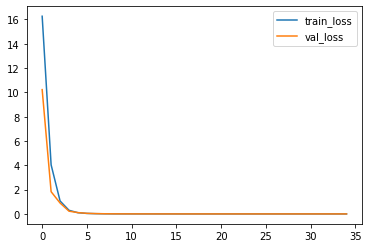

In [ ]:
print('Min Train loss:', min(his_loss))
print('Min Val loss  :', min(his_val_loss))

plt.plot(his_loss, label='train_loss')
plt.plot(his_val_loss, label='val_loss')
plt.legend()
plt.show()

## Prediction vs. Truth (Evaluation)

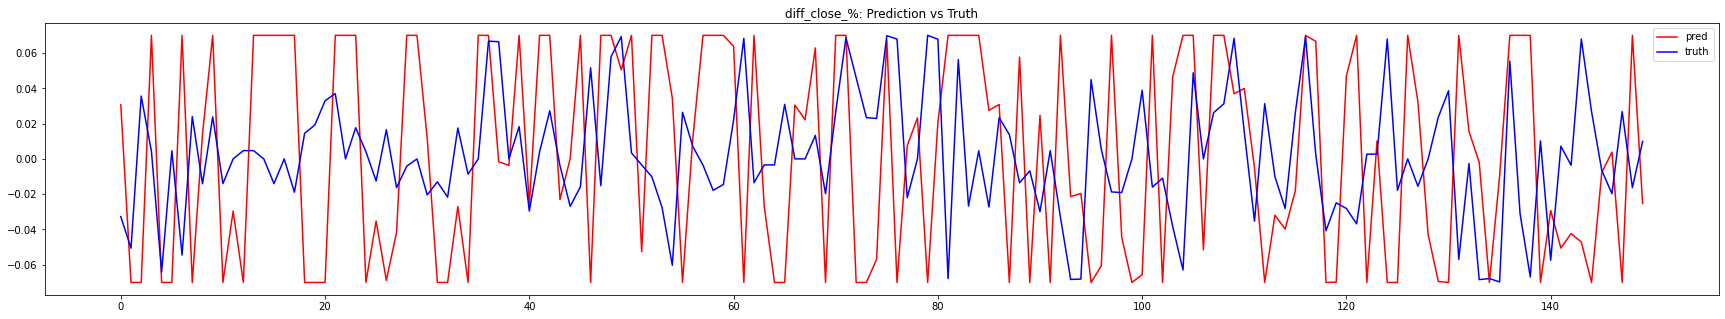

In [ ]:
plt.figure(figsize=(30,5))
plt.plot(y_pred, color='red', label='pred')
plt.plot(y_evaluate, color='blue', label='truth')
plt.legend()
plt.title(output_feat + ': Prediction vs Truth')
plt.show()

## Closing price: Prediction vs Truth (Evaluation)

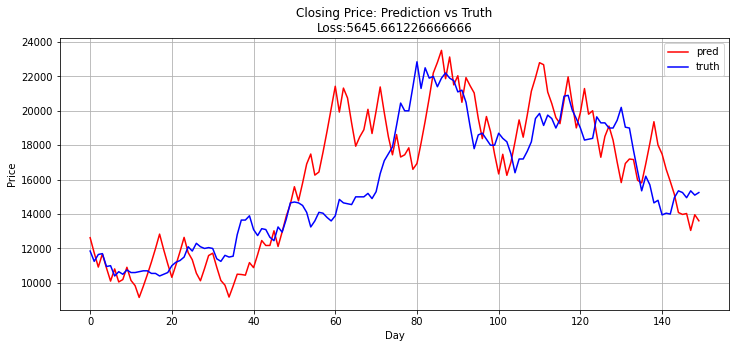

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(pred_plot_best, color='red', label='pred')
plt.plot(truth_plot, color='blue', label='truth')
plt.ylabel('Price')
plt.xlabel('Day')
plt.legend()
plt.title('Closing Price: Prediction vs Truth\nLoss:' + str(min_loss_price))
plt.grid()
plt.show()

## Closing price: Prediction vs Truth (Test)

In [ ]:
model = best_model

def get_forecast(offset=0):
  if offset > 0:
    if standardize_input:
      X_evaluate = np.array(data_standard[-length-offset:-offset]).reshape(1, length, len(features))
    else:
      X_evaluate = np.array(data[-length-offset:-offset]).reshape(1, length, len(features))
  else:
    if standardize_input:
      X_evaluate = np.array(data_standard[-length:]).reshape(1, length, len(features))
    else:
      X_evaluate = np.array(data[-length:]).reshape(1, length, len(features))

  y_pred = model.predict(X_evaluate).squeeze()
  y_pred = pd.DataFrame({output_feat: y_pred})

  if standardize_label:
    y_pred = y_pred * std + mean

  if output_feat in imbalanced:
    y_pred = np.expm1(y_pred).astype('int64')

  if output_feat[-1] == '%':
    y_pred = np.clip(y_pred[output_feat], bounds_output[0], bounds_output[1])

  pred_price = [int(truth_price[-1-offset])]

  for i, diff in enumerate(y_pred):  
      pred_price.append(int((diff + 1) * pred_price[i]))
    
  return pred_price

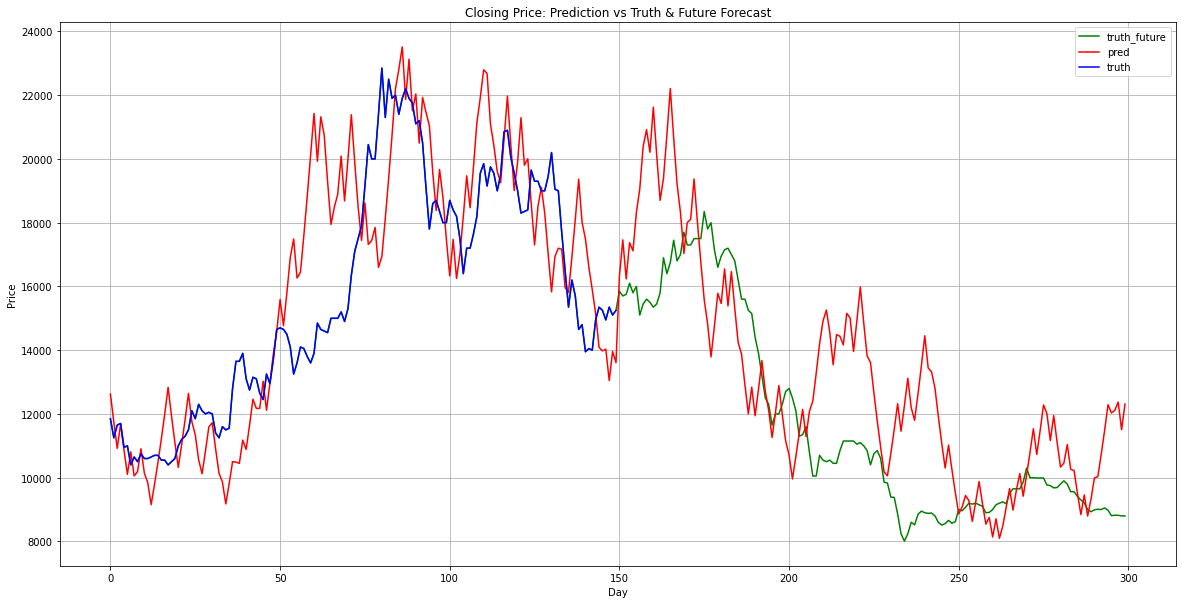

In [ ]:
plt.figure(figsize=(20,10))

truth_future = pd.read_excel('/content/drive/MyDrive/BCE/data4_future.xlsx')['close'].tolist()
plt.plot(truth_price[-forecast:] + truth_future, color='green', label='truth_future')

plt.plot(pred_plot_best + get_forecast(0)[1:], color='red', label='pred')
plt.plot(truth_price[-forecast:], color='blue', label='truth')

plt.ylabel('Price')
plt.xlabel('Day')
plt.grid()
plt.legend()
plt.title('Closing Price: Prediction vs Truth & Future Forecast')
plt.show()

pd.Series(get_forecast(0)[1:]).to_csv('/content/drive/MyDrive/BCE/predictions_test.csv')